In [2]:
#Importing necessary packages
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

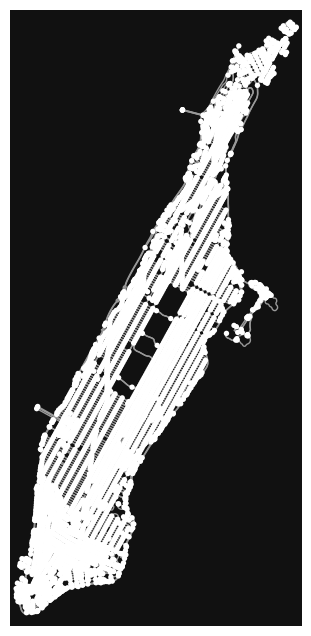

In [6]:
#Dowloading the Manhattan street network and visualizing it
G = ox.graph_from_place("Manhattan, New York, USA", network_type="drive")
fig, ax = ox.plot.plot_graph(G)

In [9]:
list(G.nodes())

[42421728,
 42421731,
 42421737,
 42421741,
 42421745,
 42421749,
 42421751,
 42421769,
 42421772,
 42421775,
 42421776,
 42421778,
 42421783,
 42421785,
 42421786,
 42421791,
 42421800,
 42421803,
 42421806,
 42421809,
 42421810,
 42421820,
 42421828,
 42421852,
 42421857,
 42421865,
 42421877,
 42421889,
 42421941,
 42421946,
 42421951,
 42421960,
 42421965,
 42421969,
 42421972,
 42421974,
 42421982,
 42421985,
 42421993,
 42421996,
 42422000,
 42422006,
 42422016,
 42422018,
 42422026,
 42422028,
 42422038,
 42422042,
 42422050,
 42422053,
 42422086,
 42422110,
 42422168,
 42422258,
 42422270,
 42422283,
 42422399,
 42422449,
 42422509,
 42422592,
 42422899,
 42423020,
 42423039,
 42423051,
 42423070,
 42423101,
 42423116,
 42423170,
 42423189,
 42423203,
 42423295,
 42423296,
 42423307,
 42423456,
 42423514,
 42423549,
 42423564,
 42423565,
 42423579,
 42423674,
 42423752,
 42423774,
 42423832,
 42423836,
 42423847,
 42423885,
 42424025,
 42424032,
 42424089,
 42424117,
 42424133,

In [7]:
#Loading the data with the firehouse coordinates
firehouse_listing = pd.read_csv("FDNY_Firehouse_Listing_20250401.csv")
firehouse_listing

,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,Engine 4/Ladder 15,42 South Street,Manhattan,10005,40.703694,-74.007717,101,1,7,1000867,1000350001,Battery Park City-Lower Manhattan
1,Engine 6,49 Beekman Street,Manhattan,10038,40.709971,-74.005395,101,1,1501,1001287,1000930030,Battery Park City-Lower Manhattan
2,Manhattan Borough Command/Battalion 1/Engine 7...,100 Duane Street,Manhattan,10007,40.715339,-74.006300,101,1,33,1001647,1001500025,SoHo-TriBeCa-Civic Center-Little Italy
3,Ladder 8,14 N. Moore Street,Manhattan,10013,40.719574,-74.006620,101,1,33,1002150,1001890035,SoHo-TriBeCa-Civic Center-Little Italy
4,Engine 9/Ladder 6,75 Canal Street,Manhattan,10002,40.715408,-73.992834,103,1,16,1003898,1003000030,Chinatown
...,...,...,...,...,...,...,...,...,...,...,...,...
214,Engine 167/Ladder 87,345 Annadale Road,Staten Island,10312,40.554191,-74.175479,503,51,17012,5075428,5056420006,Annadale-Huguenot-Prince's Bay-Eltingville
215,Engine 164/Ladder 84,1560 Drumgoole Road West,Staten Island,10312,40.535418,-74.196059,503,51,20804,5083491,5068280065,Rossville-Woodrow
216,Engine 151/Ladder 76,7219 Amboy Road,Staten Island,10307,40.512739,-74.238950,503,51,248,5089056,5080400010,Charleston-Richmond Valley-Tottenville
217,Engine 168,1100 Rossville Ave,Staten Island,10309,40.553942,-74.213083,503,51,20801,5154879,5070670252,Rossville-Woodrow


In [5]:
#Extracting the information of Manhattan fire stations only
manhattan_firestations = firehouse_listing[firehouse_listing["Borough"] == "Manhattan"]

#Now creating pairs of (latitude, longitude) of these fire stations
manhattan_firestations_coord_ls = []
for i in range(manhattan_firestations.shape[0]):
    latitude = manhattan_firestations.loc[i, "Latitude"]
    longitude = manhattan_firestations.loc[i, "Longitude"]
    manhattan_firestations_coord_ls.append((latitude, longitude))
print(manhattan_firestations_coord_ls)

[(40.703694, -74.007717), (40.709971, -74.005395), (40.715339, -74.0063), (40.719574, -74.00662), (40.715408, -73.992834), (40.716439, -73.983927), (40.721879, -73.982526), (40.731494, -73.983407), (40.723026, -73.996571), (40.726986, -73.992526), (40.733093, -73.989443), (40.734518, -74.000381), (40.756593, -73.996471), (40.753107, -73.990376), (40.741196, -73.996868), (40.748474, -73.991188), (40.737948, -73.991035), (40.741676, -73.97888), (40.748642, -73.974027), (40.76072, -73.986793), (40.766699, -73.980368), (40.774562, -73.984225), (40.78223, -73.979841), (40.784697, -73.974602), (40.756891, -73.970805), (40.771454, -73.958154), (40.778622, -73.955311), (40.798913, -73.947333), (40.788923, -73.946985), (40.793843, -73.940791), (40.803297, -73.936522), (40.796449, -73.967261), (40.804946, -73.962932), (40.813332, -73.94245), (40.811921, -73.9546), (40.835918, -73.940959), (40.864897, -73.925154), (40.719841, -73.99576), (40.760727, -73.996616), (40.767062, -73.963612), (40.82084